In [1]:
# import sys
# sys.path.append('../')
# from src import load_dataset

import codecs, re, os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import nltk
from nltk.corpus import stopwords

def load_dataset(
    path="../data/raw/corpus.tache1.learn.utf8",
):
    corpus = []
    classes = []
    f = codecs.open(path, "r", "utf-8")  # pour régler le codage
    while True:
        texte = f.readline()
        if (len(texte)) < 5:
            break
        label = re.sub(r"<\d*:\d*:(.)>.*", "\\1", texte)
        texte = re.sub(r"<\d*:\d*:.>(.*)", "\\1", texte)
        if label.count("M") > 0:
            classes.append(-1)
        else:
            classes.append(1)
        corpus.append(texte)
    return np.array(corpus), np.array(classes)

# Données reconnaissance du locuteur (Chirac/Mitterrand)

## Analyse préliminaire

In [2]:
alltxts, alllabs = load_dataset()

print(f"Nombre de phrases [classes] : {len(alltxts)} [{len(alllabs)}]")
print(f"[Classe : {alllabs[0]}]", alltxts[0].rstrip())
print(f"[Classe : {alllabs[-1]}]", alltxts[-1].rstrip())
print(f"[Classe : {alllabs[12]}]", alltxts[12].rstrip())

print("Nombre de phrases prononcés par Chirac :", np.sum(np.array(alllabs) == 1), np.sum(np.array(alllabs) == 1) / len(alltxts) * 100, "%")
print("Nombre de phrases prononcés par Mitterand :", np.sum(np.array(alllabs) == -1), np.sum(np.array(alllabs) == -1) / len(alltxts) * 100, "%")

Nombre de phrases [classes] : 57413 [57413]
[Classe : 1]  Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.
[Classe : 1]  Je compte sur vous.
[Classe : -1]  C'est vrai qu'il y a très souvent dans notre pays un refus de regarder droit devant soi, comme un souhait d'en rester là, une certaine peur du changement, c'est vrai.
Nombre de phrases prononcés par Chirac : 49890 86.89669587027329 %
Nombre de phrases prononcés par Mitterand : 7523 13.103304129726718 %


Très rapidement on s'aperçoit d'un problème d'équilibrage dans notre jeu de données : preque 9 phrases sur 10 ont été prononcés par Chirac.

*Note* : 
- 1 correspond à Chirac (C)
- -1 correspond à Mitterand (M)

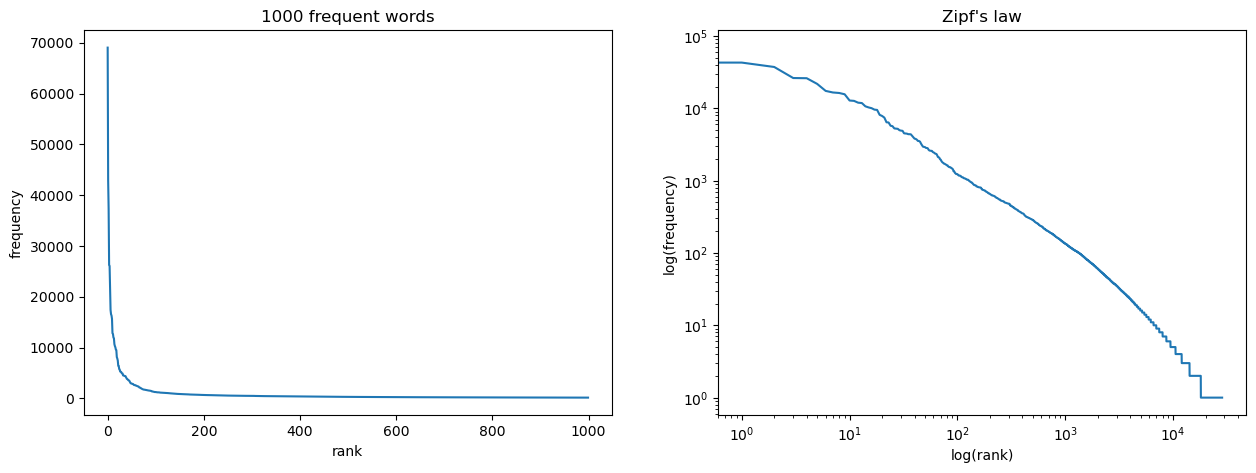

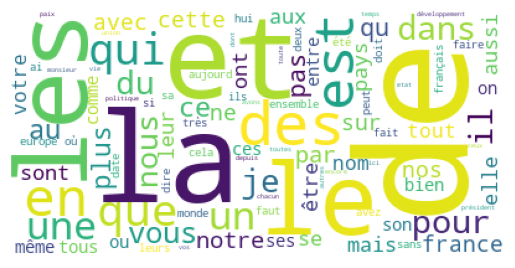

20 most frequent words
de      69031
la      42863
et      37281
le      26219
les     26067
des     21768
est     17401
en      16553
que     16292
qui     15635
un      12815
une     12669
pour    11964
dans    11820
du      10659
je      10286
il      10037
nous     9590
vous     9499
au       8122
dtype: int64


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

## BoW (without stopwords)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(alltxts)
frequent_words = pd.Series(np.array(X.sum(axis=0))[0], index = sorted(vectorizer.vocabulary_))

## Zipf's law
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(range(1000), frequent_words.sort_values(ascending=False)[:1000], "-")
plt.ylabel("frequency")
plt.xlabel("rank")
plt.title("1000 frequent words")
plt.subplot(122)
plt.plot(frequent_words.sort_values(ascending=False))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.title("Zipf's law")
plt.savefig("../reports/figures/zipfs_nostopwords.png", dpi=100, bbox_inches="tight")
plt.show()

## 100 most frequent words
wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate_from_frequencies(frequent_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("../reports/figures/wordcloud_nostopwords.png", dpi=100, bbox_inches="tight")
plt.show()

## 
print("20 most frequent words")
print(frequent_words.sort_values(ascending=False)[:20])

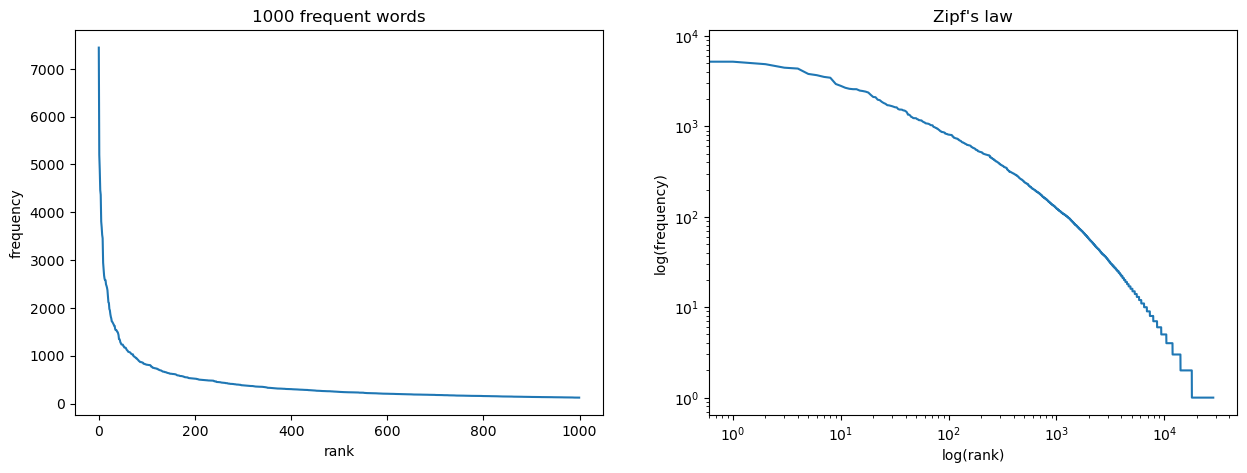

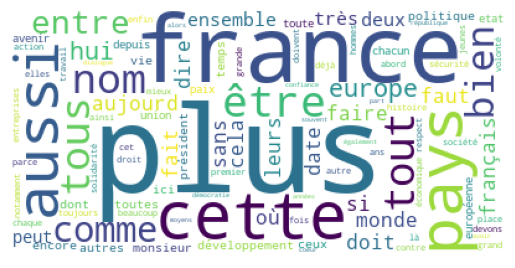

20 most frequent words
plus        7443
france      5201
cette       4883
pays        4464
aussi       4366
être        3808
tout        3688
nom         3530
tous        3457
bien        2945
comme       2811
entre       2678
europe      2609
hui         2582
aujourd     2581
monde       2492
doit        2463
faire       2426
français    2371
si          2231
dtype: int64


In [4]:
## BoW (with stopwords)
vectorizer = CountVectorizer(stop_words=stopwords.words("french"))
X = vectorizer.fit_transform(alltxts)
frequent_words = pd.Series(np.array(X.sum(axis=0))[0], index = sorted(vectorizer.vocabulary_))

## Zipf's law
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(range(1000), frequent_words.sort_values(ascending=False)[:1000], "-")
plt.ylabel("frequency")
plt.xlabel("rank")
plt.title("1000 frequent words")
plt.subplot(122)
plt.plot(frequent_words.sort_values(ascending=False))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.title("Zipf's law")
plt.savefig("../reports/figures/zipfs_stopwords.png", dpi=100, bbox_inches="tight")
plt.show()

## 100 most frequent words
wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate_from_frequencies(frequent_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("../reports/figures/wordcloud_stopwords.png", dpi=100, bbox_inches="tight")
plt.show()

## 
print("20 most frequent words")
print(frequent_words.sort_values(ascending=False)[:20])

## Un peu de dataviz 

In [5]:
def save_wordcloud(filepath, label, mask_wc, mask_out, n_words=1000):
    """Draw and save locally word cloud from given class.
    
    Arguments:
        filepath: A filename (string), pathlib.Path object or file object.
        label: A number corresponding to a class (label) of our documents.
        mask_wc: A mask image used to draw the word cloud.
        mask_out: A mask image used to draw the data viz.T
        n_words: A number of words. 
    """
    ## Initialize CountVectorize to generate our word cloud from frequencies
    vectorizer = CountVectorizer(stop_words=stopwords.words("french"), lowercase=False)
    X = vectorizer.fit_transform(np.array(alltxts)[np.array(alllabs) == label])
    freq = pd.Series(np.array(X.sum(axis=0))[0], index = sorted(vectorizer.vocabulary_))
    ## Draw the word cloud
    wc = WordCloud(
        background_color=None,
        max_words=n_words,
        mask=mask_wc,
        mode="RGBA",
        contour_width=1,
        contour_color="#292929",
    )
    wc = wc.generate_from_frequencies(freq).to_array()
    ## Save the word cloud
    img = Image.fromarray(wc)
    mask_out.paste(img, (0,0), mask=img)
    mask_out.save(filepath)


In [9]:
for mask in ['Chirac_Assis', 'Chirac_Portrait', 'Mitterrand_Assis', 'Mitterrand_Portrait']:
    mask_wc = np.array(Image.open(f"./img/{mask}.png"))
    mask_out = Image.open(f"./img/{mask}_color.png")
    fp = f"../reports/figures/{mask}_WC.png"
    if "Chirac" in mask:
        save_wordcloud(fp, 1, mask_wc, mask_out, n_words=200)
    if "Mitterrand" in mask:
        save_wordcloud(fp, -1, mask_wc, mask_out, n_words=200)